# **Concrete compressive strength prediction**

**Content**

1. Import data and python packages

2.  Read Dataset

3. Variable Description

4. Exploratory Data Analysis

5. Data Preprocessing

    * clean data
    * log transformation
    * Train Test split
 
6. Machine learning modell

    *  Linear Regression
    *  Lasso Regression

7. Evaluation


## **Import libary**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PowerTransformer

from sklearn.linear_model import LinearRegression, RidgeCV, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer

## **Read dataset**

ข้อมูล [Concrete compressive strength](https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength) เป็นข้อมูลส่วนผสมของคอนกรีตที่มีผลต่อกำลังอัดของคอนกรีตจาก [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php)

In [2]:
con_data = pd.read_excel('/content/drive/MyDrive/datasets/concrete/Concrete_Data.xls')

In [3]:
con_data.head()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


In [4]:
con_data.shape

(1030, 9)

## **Variable Description**

## **Explorary data analysis**

ขั้นตอนสำคัญเพื่อช่วยให้การทำ preprocessing ได้ดีขึ้นและช่วยให้เข้าใจข้อมูลที่มีได้ดีมากยิ่งขึ้น

In [5]:
con_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Cement (component 1)(kg in a m^3 mixture)              1030 non-null   float64
 1   Blast Furnace Slag (component 2)(kg in a m^3 mixture)  1030 non-null   float64
 2   Fly Ash (component 3)(kg in a m^3 mixture)             1030 non-null   float64
 3   Water  (component 4)(kg in a m^3 mixture)              1030 non-null   float64
 4   Superplasticizer (component 5)(kg in a m^3 mixture)    1030 non-null   float64
 5   Coarse Aggregate  (component 6)(kg in a m^3 mixture)   1030 non-null   float64
 6   Fine Aggregate (component 7)(kg in a m^3 mixture)      1030 non-null   float64
 7   Age (day)                                              1030 non-null   int64  
 8   Concrete compressive strength(MPa, megapascals)  

In [6]:
con_data.describe()

,Cement (component 1)(kg in a m^3 mixture),Blast Furnace Slag (component 2)(kg in a m^3 mixture),Fly Ash (component 3)(kg in a m^3 mixture),Water (component 4)(kg in a m^3 mixture),Superplasticizer (component 5)(kg in a m^3 mixture),Coarse Aggregate (component 6)(kg in a m^3 mixture),Fine Aggregate (component 7)(kg in a m^3 mixture),Age (day),"Concrete compressive strength(MPa, megapascals)"
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.165631,73.895485,54.187136,181.566359,6.203112,972.918592,773.578883,45.662136,35.817836
std,104.507142,86.279104,63.996469,21.355567,5.973492,77.753818,80.175427,63.169912,16.705679
min,102.000000,0.000000,0.000000,121.750000,0.000000,801.000000,594.000000,1.000000,2.331808
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.707115
50%,272.900000,22.000000,0.000000,185.000000,6.350000,968.000000,779.510000,28.000000,34.442774
75%,350.000000,142.950000,118.270000,192.000000,10.160000,1029.400000,824.000000,56.000000,46.136287
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.599225


เปลี่ยนชื่อ Column เพื่อให้ง่ายต่อการ plot

In [7]:
column_name_new = ['Cement', 'BFS', 'Fly Ash', 'Water', 'Superplasticizer', 'Coarse Aggregate', 'Fine Aggregate', 'Age', 'strength']
name_change = { i : j for i, j in zip(con_data.columns, column_name_new) }
con_data = con_data.rename(columns=name_change)

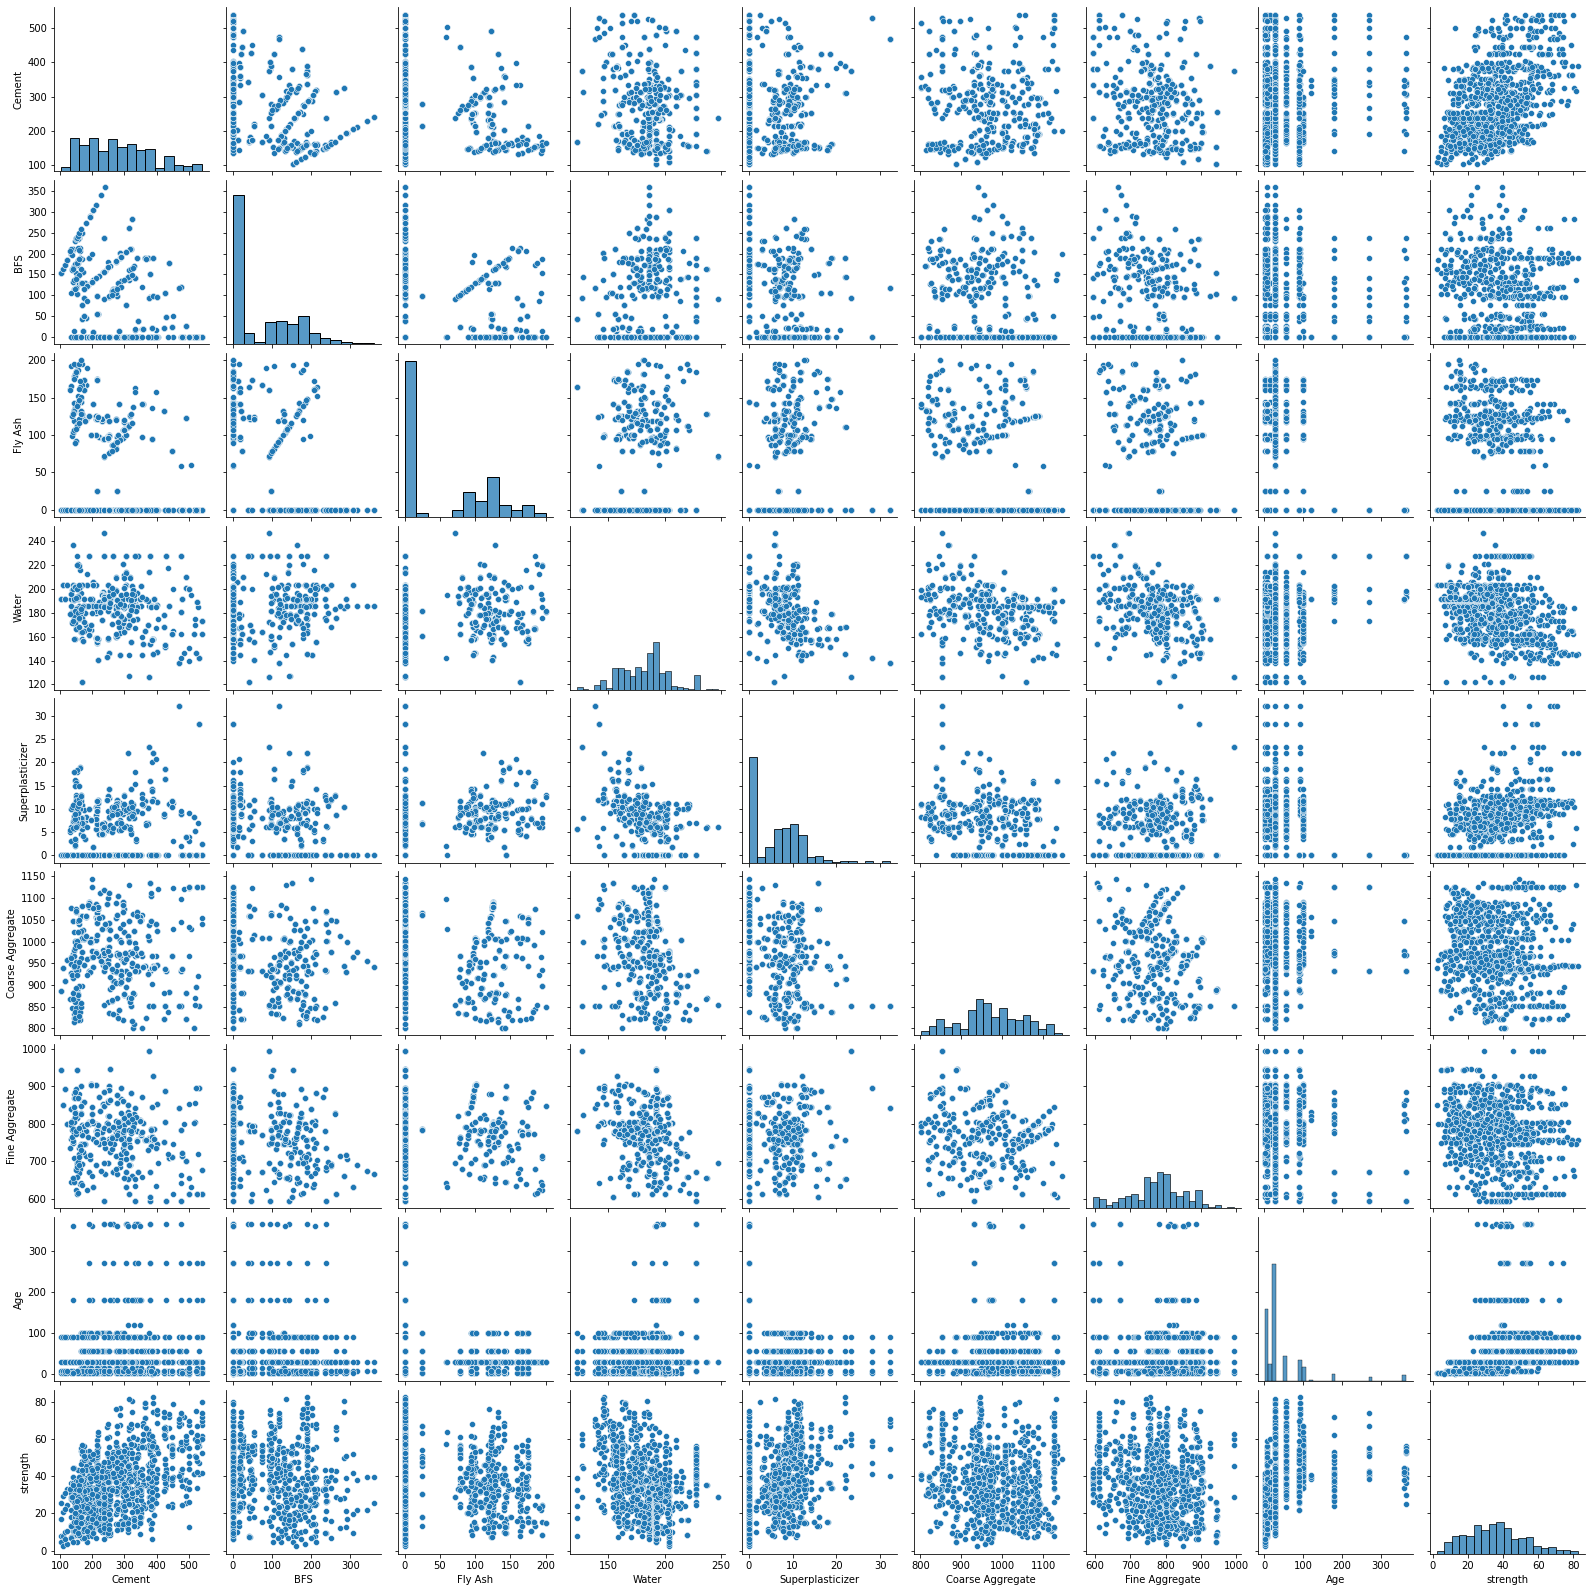

In [8]:
sns.pairplot(con_data)

แสดงการกระจายตัวของข้อมูลแต่ละส่วนผสมของคอนกรีตด้วย Histogram plot

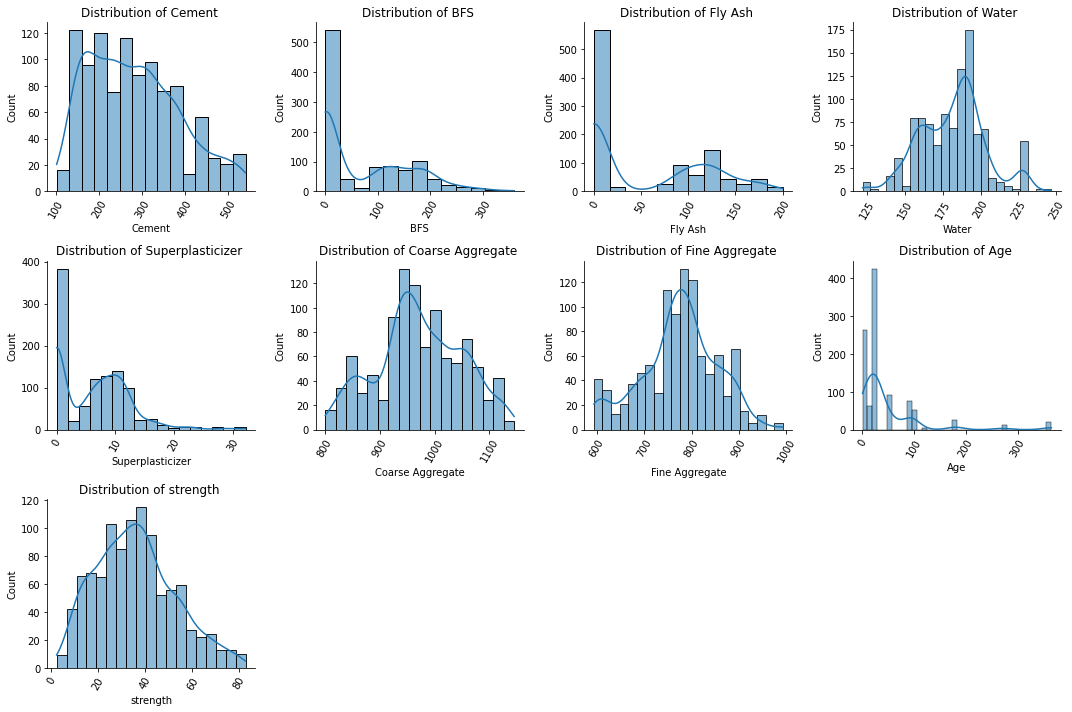

In [9]:
plt.figure(figsize=[15,10])

for n, col in enumerate(con_data,1):
    plt.subplot(3,4,n)
    ax = sns.histplot(con_data[col], kde=True)
    sns.despine()
    plt.title("Distribution of {} ".format(col))
    plt.xticks(rotation=60)
plt.tight_layout()
plt.show()


แสดงจำนวนของ Ourlier ของแต่ละส่วนผสมด้วย Boxplot



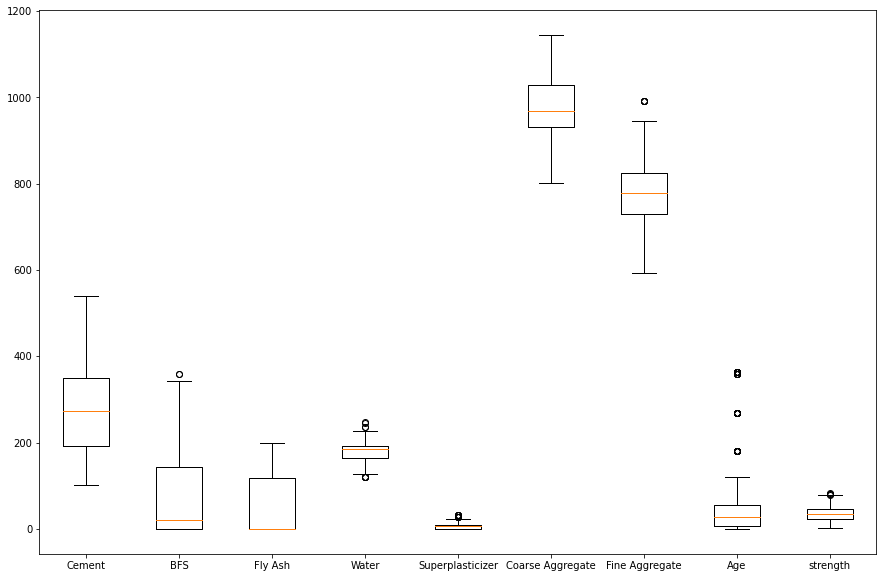

In [10]:
Cement = con_data["Cement"]
BFS = con_data['BFS']
Fly_Ash = con_data['Fly Ash']
Water = con_data['Water']
Superplasticizer = con_data['Superplasticizer']
Coarse_Aggregate = con_data['Coarse Aggregate']
Fine_Aggregate = con_data['Fine Aggregate']
Age = con_data['Age']
strength = con_data['strength']

columns = [Cement, BFS, Fly_Ash, Water, Superplasticizer, Coarse_Aggregate, Fine_Aggregate, Age, strength]

fig, ax = plt.subplots(figsize=(15,10))
ax.boxplot(columns)
ax.set_xticklabels(['Cement', 'BFS', 'Fly Ash', 'Water', 'Superplasticizer', 'Coarse Aggregate', 'Fine Aggregate', 'Age', 'strength'])
plt.show()

แสดงความสัมพันธ์ระหว่างแต่ละ Feature ด้วย Heatmap

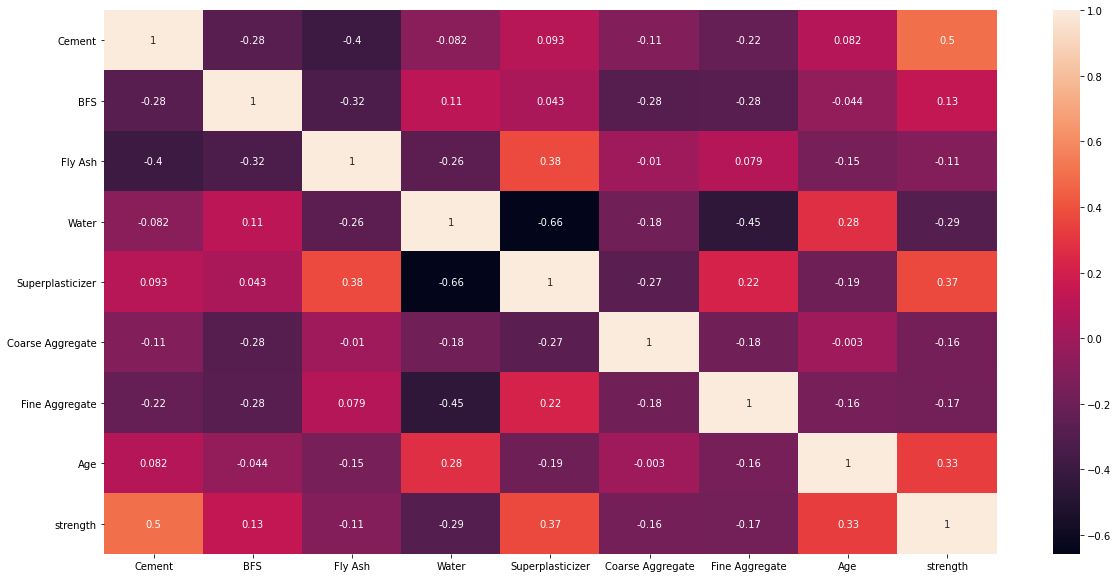

In [11]:
fig= plt.figure(figsize=(20,10))
sns.heatmap(con_data.corr(), annot = True)
plt.show()

จะเห็นได้ว่าข้อมูลใน dataset จะเป็น numarical ทั้งหมด ในส่วนของการกระจายตัวของข้อมูล บาง feature จะมีการกระจายตัวแบบ skewed distribution และปริมาณของ Ourlier ในข้อมูลจะมีอยู่เล็กน้อย และในส่วนของความสัมพันธ์ของแต่ละ feature นั้นจะพบว่าแต่ละ feature มีความสัมพันธ์ต่อ target เป็นอย่างดี

## **Data Prepocessing**

หลังจากเข้าใจข้อมูลเป็นอย่างดีแล้ว ในส่วนนี้เป็นส่วนสำคัญที่จะเป็นการทำให้ Model สามารถถูก train ได้อย่างดีขึ้น โดยมีขั้นตอนต่อไปนี้

*  Clean data : เพื่อป้องกันไม่ให้ข้อมูลผิดไปจากความเป็นจริงจำเป็นต้องทำความสะอาดข้อมูลให้พร้อมต่อการ Train

*  Log transformation : เพื่อให้ข้อมูลมีการกระจายตัวแบบปกติและลดจำนวนของ Ourlier จึงนำ logarithm นำมาทำ Normalization เพื่อลดปัญหาที่เกิดขึ้น

* Train Test split : ก่อนการนำข้อมูลเข้าไปเทรนกับโมเดล จำเป็นต้องแบบข้อมูลออกเป็น Train กับ Test ในการทำ Evaluation เพื่อทำให้ได้โมเดลที่เหมาะสม


### **Clean data**

ตรวจสอบข้อมูลที่ซ้ำกัน

In [12]:
con_data.duplicated().sum()

25

ตรวจสอบข้อมูลที่เป็น NaN

In [13]:
con_data.isnull().sum()

Cement              0
BFS                 0
Fly Ash             0
Water               0
Superplasticizer    0
Coarse Aggregate    0
Fine Aggregate      0
Age                 0
strength            0
dtype: int64

ลบข้อมูลที่ซ้ำกันออก

In [14]:
con_data = con_data.drop_duplicates()

### **log transformation**

จากการทำ Explorary data analysis จะเห็นได้ว่าข้อมูลบางส่วนจะมีการกระจายตัวแบบ skewed distribution และมี Ourlier เล็กน้อย จึงเลือกใช้ logarithm ในการทำ Normalization

In [15]:
con_data_log = con_data.copy()
for c in [c for c in con_data.columns]:
  con_data_log[c] = np.log(con_data[c] + 1)

### **Train Test split**

แบ่งข้อมูล input และ target ออกจากกัน จากนั้นแบ่งทั้งสองอย่างออกข้อมูลสำหรับ Train และ Test สำหรับทำ Model และการวัดผล

In [16]:
 X = con_data_log.drop(['strength'], axis =1)
y = con_data_log.strength
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2475)

## **Machine Learning model**

เริ่มการเทรนข้อมูลที่ได้จากการทำ preprocessing มาเทรนกับโมเดลต่างๆต่อไปนี้

*  Linear Regression

*  Ride Regression

*  Lasso Regression

*  Elastic Net Regression

*  Random Forest

*  Artificial Neuron Network

In [17]:
mae = make_scorer(mean_absolute_error)
mse = make_scorer(mean_squared_error)
r2 = make_scorer(r2_score)
def eval_CV_train(model):
  mae_train = cross_val_score(model, X_train, y_train, scoring = mae, cv=10)
  mse_train = cross_val_score(model, X_train, y_train, scoring = mse, cv=10)
  rmse_train = np.sqrt(cross_val_score(model, X_train, y_train, scoring = mse, cv=10))
  r2_train = cross_val_score(model, X_train, y_train, scoring = r2, cv=10)
  print('Evaluation on Train set')
  print('MAE : ', mae_train.mean())
  print('MSE : ', mse_train.mean())
  print('RMSE : ', rmse_train.mean())
  print('R2 : ', r2_train.mean())

def eval_CV_test(model):
  mae_test = cross_val_score(model, X_test, y_test, scoring = mae, cv=10)
  mse_test = cross_val_score(model, X_test, y_test, scoring = mse, cv=10)
  rmse_test = np.sqrt(cross_val_score(model, X_test, y_test, scoring = mse, cv=10))
  r2_test = cross_val_score(model, X_test, y_test, scoring = r2, cv=10)
  print('Evaluation on Test set')
  print('MAE : ', mae_test.mean())
  print('MSE : ', mse_test.mean())
  print('RMSE : ', rmse_test.mean())
  print('R2 : ', r2_test.mean())

### **Linear Regression**

โมเดลอย่างง่ายที่เหมาะสำหรับใช้ในการแก้ไขปัญหาแบบ regression problem ที่สามารถทำนายผลลัพธ์แบบ  continuous outcome

In [18]:
reg  = LinearRegression()
reg.fit(X_train, y_train)
eval_CV_train(reg)
eval_CV_test(reg)

Evaluation on Train set
MAE :  0.18975466549210263
MSE :  0.0601176312104685
RMSE :  0.2446154000772486
R2 :  0.779199780991071
Evaluation on Test set
MAE :  0.18195655373145142
MSE :  0.055761146263473636
RMSE :  0.2319025104998972
R2 :  0.7633073342013995


### **Ridge Regression**

ทอลองเทรนโมเดลด้วย Ridge ซึ้งเป็นวิธี regularization โมเดลเพื่อป้อมกันการเกิด Overfitting

In [19]:
ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(X_train,y_train)
alpha = ridge.alpha_
print('best alpha',alpha)
eval_CV_train(ridge)
eval_CV_test(ridge)

best alpha 0.3
Evaluation on Train set
MAE :  0.1899485142391037
MSE :  0.06012216767242342
RMSE :  0.24461267127720845
R2 :  0.7792307914014142
Evaluation on Test set
MAE :  0.18119020695237692
MSE :  0.055246870031712594
RMSE :  0.2300676726310491
R2 :  0.7679208799133879


### **Lasso Regression**

โมเดลนี้เป็นอีกหนึ่งวิธีการ regularization เหมือนกับ Ridge Regression และ โมลเดลนี้จะช่วยให้ generalize มากขึ้น

In [20]:
lass = Lasso(alpha=0.00001)
lass.fit(X_train,y_train)

eval_CV_train(lass)
eval_CV_test(lass)

Evaluation on Train set
MAE :  0.18975506517061042
MSE :  0.06010766137059951
RMSE :  0.24459514248843456
R2 :  0.7792362318521997
Evaluation on Test set
MAE :  0.18196097562761862
MSE :  0.055761882122732365
RMSE :  0.23190101608010902
R2 :  0.763321673248327


### **Elastic Net Regression**

โมเดลนี้เป็นส่วนผสมระหว่างเทคนิคของทั้ง Ridge และ Lasso โมเดลนี้จะมีประโยชน์มากเมื่อหลายๆ Feature มีค่าความสัมพันธ์กันสูง

In [21]:
Enet = ElasticNet(alpha=0.0001, l1_ratio=0.9, selection='random', random_state=42)
Enet.fit(X_train, y_train)
eval_CV_train(Enet)
eval_CV_test(Enet)

Evaluation on Train set
MAE :  0.18975756475101063
MSE :  0.060051154761273054
RMSE :  0.24448100753792543
R2 :  0.7794347859555716
Evaluation on Test set
MAE :  0.18198853934315024
MSE :  0.05576067182073456
RMSE :  0.23187010793459395
R2 :  0.7634769616927839


### **Random Forest**

Random Forest เป็นอีกขึ้นของโมเดลปกติที่มีความซับซ้อนมากยิ่งขึ้น ที่จะเพิ่มประสิทธิภาพของการทำงานของโมเดลด้วยวิธีการ Ensemble Learning 

เซ็ต Parameter ต่างๆที่จะใช้ในการทำ hyperparameter tuning

In [22]:
n_estimators = list(map(int, np.linspace(start = 100, stop = 1000, num = 10)))

max_depth = list(map(int, np.linspace(10, 110, num = 11)))
max_depth.append(None)

max_features = ['auto', 'sqrt', 'log2']

min_samples_split = [2, 4, 6, 10]

min_samples_leaf = [1, 2, 4]

bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

ใช้ random search cross validation ในการหา hyperparameter ที่เหมาะสมสำหรับโมเดลนี้

In [23]:
rf_tun = RandomForestRegressor()

rf_random = RandomizedSearchCV(estimator = rf_tun, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)

rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.9min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

แสดงค่า hyperparameter ที่ได้จากการเทรน

In [24]:
rf_random.best_params_

{'bootstrap': False,
 'max_depth': 40,
 'max_features': 'log2',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 800}

In [25]:
rf_best = rf_random.best_estimator_
eval_CV_train(rf_best)
eval_CV_test(rf_best)

Evaluation on Train set
MAE :  0.10244530284131999
MSE :  0.024949777225887277
RMSE :  0.1571585709503524
R2 :  0.9088907150777873
Evaluation on Test set
MAE :  0.16269566932545435
MSE :  0.05201384152453396
RMSE :  0.22339800438578988
R2 :  0.7536472187707767


### **Artificial Neuron Network**

โมเดลที่มีความซับซ้อนสูง มีความสามารถในการเรียนรู้ Non-linear model และโมเดลที่ควาสัมพันธ์ซับซ้อนได้ดี

In [31]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

ANN = Sequential()

ANN.add(Dense(X_train.shape[1], activation='relu'))
ANN.add(Dense(256, activation='relu'))
ANN.add(Dense(512, activation='relu'))
ANN.add(Dense(1024, activation='relu'))
ANN.add(Dense(2048, activation='relu'))
ANN.add(Dropout(0.1))
ANN.add(Dense(1))

ANN.compile(optimizer=Adam(0.00001), loss='mse')

r = ANN.fit(X_train, y_train,
              validation_data=(X_test,y_test),
              batch_size=4,
              epochs=100)

Epoch 1/100
201/201 [==============================] - 1s 2ms/step - loss: 9.0713 - val_loss: 3.6117
Epoch 2/100
201/201 [==============================] - 0s 2ms/step - loss: 2.8183 - val_loss: 2.9840
Epoch 3/100
201/201 [==============================] - 0s 2ms/step - loss: 2.1057 - val_loss: 2.3911
Epoch 4/100
201/201 [==============================] - 0s 2ms/step - loss: 1.9434 - val_loss: 1.7797
Epoch 5/100
201/201 [==============================] - 0s 2ms/step - loss: 1.4392 - val_loss: 1.0658
Epoch 6/100
201/201 [==============================] - 0s 2ms/step - loss: 0.7846 - val_loss: 0.5500
Epoch 7/100
201/201 [==============================] - 0s 2ms/step - loss: 0.4717 - val_loss: 0.3692
Epoch 8/100
201/201 [==============================] - 0s 2ms/step - loss: 0.3871 - val_loss: 0.3203
Epoch 9/100
201/201 [==============================] - 0s 2ms/step - loss: 0.3477 - val_loss: 0.3266
Epoch 10/100
201/201 [==============================] - 0s 2ms/step - loss: 0.3426 - val_lo

## **Evaluation**

วัดประสิทธิภาพของโมเดลวิธีดดังต่อไปนี้

*  Mean Absolute Error : ค่านี้ได้มาจากการนำค่า Error มาใส่ Absolute ก่อนที่จะนำมาหาค่าเฉลี่ยของ Error

*  Mean Square Error : ค่าที่ได้นั้นเกิดจากการที่จำทำ Error ให้เป็นบวกด้วยการยกกำลังสอง แล้วนำมาหาค่าเฉลี่ย

*  Root Mean Square Error : เป็นการนำ MSE มาใส่ Square Root ทำให้ค่าที่ได้นั้นมีหน่วยเหมือนกันกับค่าที่โมเดลทำนาย

*  R-squared : เป็นค่าที่สามารถบอกถึงความมากหรือน้อยของความสัมพันธ์ระหว่างตัวแปรอิสระและตัวแปรตามในโมเดลได้ ทีค่าระหว่าง 0 - 100%

In [27]:
model = [reg, ridge, lass, Enet, rf_best]

MAE_train = np.empty(len(model))
MSE_train = np.empty(len(model))
RMSE_train = np.empty(len(model))
R2_train = np.empty(len(model))

MAE_test = np.empty(len(model))
MSE_test = np.empty(len(model))
RMSE_test = np.empty(len(model))
R2_test = np.empty(len(model))

for i,model in enumerate(model):
  MAE_train[i] = cross_val_score(model, X_train, y_train, scoring = mae, cv=10).mean()
  MSE_train[i] = cross_val_score(model, X_train, y_train, scoring = mse, cv=10).mean()
  RMSE_train[i] = np.sqrt(cross_val_score(model, X_train, y_train, scoring = mse, cv=10)).mean()
  R2_train[i] = cross_val_score(model, X_train, y_train, scoring = r2, cv=10).mean()

  MAE_test[i] = cross_val_score(model, X_test, y_test, scoring = mae, cv=10).mean()
  MSE_test[i] = cross_val_score(model, X_test, y_test, scoring = mse, cv=10).mean()
  RMSE_test[i] = np.sqrt(cross_val_score(model, X_test, y_test, scoring = mse, cv=10)).mean()
  R2_test[i] = cross_val_score(model, X_test, y_test, scoring = r2, cv=10).mean()

ANN_eval_train = pd.DataFrame({
                'Models': ['Artificial Neuron Network'],
                'MAE':  mean_absolute_error(y_train , ANN.predict(X_train)),
                'MSE':  mean_squared_error(y_train , ANN.predict(X_train)),
                'RMSE':  np.sqrt(mean_squared_error(y_train , ANN.predict(X_train))),
                'R2':  r2_score(y_train , ANN.predict(X_train)),
                })

ANN_eval_test = pd.DataFrame({
                'Models': ['Artificial Neuron Network'],
                'MAE':  mean_absolute_error(y_test , ANN.predict(X_test)),
                'MSE':  mean_squared_error(y_test , ANN.predict(X_test)),
                'RMSE':  np.sqrt(mean_squared_error(y_test , ANN.predict(X_test))),
                'R2':  r2_score(y_test , ANN.predict(X_test)),
                })

Train_eval = pd.DataFrame({
                'Models': ['Linear Regression', 'Ridge Regression', 'LASSO Regression',
                           'Elastic Net', 'Random Forest'],
                'MAE':  MAE_train,
                'MSE':  MSE_train,
                'RMSE':  RMSE_train,
                'R2':  R2_train,
                })

Test_eval = pd.DataFrame({
                'Models': ['Linear Regression', 'Ridge Regression', 'LASSO Regression',
                           'Elastic Net', 'Random Forest'],
                'MAE':  MAE_test,
                'MSE':  MSE_test,
                'RMSE':  RMSE_test,
                'R2':  R2_test,
                })
train = Train_eval.append(ANN_eval_train).reset_index(drop=True)
test = Test_eval.append(ANN_eval_test).reset_index(drop=True)

In [28]:
print('Evaluation of train data : \n')
train

Evaluation of train data : 



,Models,MAE,MSE,RMSE,R2
0,Linear Regression,0.189755,0.060118,0.244615,0.779200
1,Ridge Regression,0.189949,0.060122,0.244613,0.779231
2,LASSO Regression,0.189755,0.060108,0.244595,0.779236
3,Elastic Net,0.189758,0.060051,0.244481,0.779435
4,Random Forest,0.102598,0.025021,0.156593,0.908904
5,Artificial Neuron Network,0.219548,0.075988,0.275659,0.726331


In [29]:
print('Evaluation of test data : \n')
test

Evaluation of test data : 



,Models,MAE,MSE,RMSE,R2
0,Linear Regression,0.181957,0.055761,0.231903,0.763307
1,Ridge Regression,0.181190,0.055247,0.230068,0.767921
2,LASSO Regression,0.181961,0.055762,0.231901,0.763322
3,Elastic Net,0.181989,0.055761,0.231870,0.763477
4,Random Forest,0.162490,0.051055,0.222718,0.755503
5,Artificial Neuron Network,0.215043,0.070138,0.264837,0.723963
